# Business problem
### Background:
As the COVID-19 pandemic attack the U.S. economy, it provides the best time to put house on the market due to low inventory and high demand. The low interest rate has attract investors heating up the housing market. However, it is difficult for unfamiliar investor to collect housing information.

### Business Problem:
In this senerio, a newly-formed real estate company, ABC inc., is searching for investors who are inexperienced with the real estate market in Bronx. The company's goal is to collect information to attract new investors and assist new investor to make a profitable purchase.

The Conmpany's plan is to use clustering method to classfy neighboods in Bronx and recommending suitable price and venues for their new investors. 

### Data Selection
The data of housing price in Bronx can be access through the open source from New York City Government (link: https://www1.nyc.gov/site/finance/taxes/property-rolling-sales-data.page). It included all the rolling sales for past 12 months and it excluded the utility properties.

In order to analyze and designate location between different vecnues, we will evaluate amenities and essential facilities in each region using the data provided by FourSquare API interface. Then we will use the venue data  to generate a report with visualization. The venue data  from the API includes a neighborhood's name, neighborhood's latitude, lneighborhood's ongtitude, venue, venue's name, venue's latitude, and venue's logititude.
### Methodology:
In this case, I'll use data cleaning methods from IBM data science class and KNN and KMeansclustering for modeling.
The specific process is showned below

In [2]:
#Import libraries
import pandas as pd
import numpy as np
import pickle
import requests
import urllib
import json
import csv

import matplotlib.pyplot as plt 
%matplotlib inline
import matplotlib.cm as cm
import matplotlib.colors as colors

import folium
from folium import plugins

from geopy.geocoders import Nominatim
from pandas.io.json import json_normalize
from sklearn.cluster import KMeans
from bs4 import BeautifulSoup


print('succesfully import all the libraries...')

succesfully import all the libraries...


In [3]:
with open('Data/newyork_data.json') as json_data:
    newyork_data = json.load(json_data)

In [4]:
neighborhoods_data = newyork_data['features']

#### Tranform the data into a *pandas* dataframe

In [5]:
# define the dataframe columns
column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 

# instantiate the dataframe
neighborhoods = pd.DataFrame(columns=column_names)

# loop through the data and fill the dataframe one row at a time.
for data in neighborhoods_data:
    borough = neighborhood_name = data['properties']['borough'] 
    neighborhood_name = data['properties']['name']
        
    neighborhood_latlon = data['geometry']['coordinates']
    neighborhood_lat = neighborhood_latlon[1]
    neighborhood_lon = neighborhood_latlon[0]
    
    neighborhoods = neighborhoods.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)

#### Extract dataset about Bronx 

In [6]:
Bronx_data = neighborhoods[neighborhoods['Borough'] == 'Bronx']
Bronx_data.head(10)

,Borough,Neighborhood,Latitude,Longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585
5,Bronx,Kingsbridge,40.881687,-73.902818
7,Bronx,Woodlawn,40.898273,-73.867315
8,Bronx,Norwood,40.877224,-73.879391
9,Bronx,Williamsbridge,40.881039,-73.857446
10,Bronx,Baychester,40.866858,-73.835798


#### Use geopy library to get the latitude and longitude values of Bronx, New York .

In [7]:
address_man = 'Bronx, New York'
latitude_man = Bronx_data.iloc[0,2]
longitude_man = Bronx_data.iloc[0,3]
print('The geograpical coordinate of "Bronx" are: {}, {}.'.format(latitude_man, longitude_man))

map_Bronx = folium.Map(location=[latitude_man, longitude_man], zoom_start=11.5)

# add markers to map
for lat, lng, label in zip(Bronx_data['Latitude'], Bronx_data['Longitude'], Bronx_data['Neighborhood']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius = 10,
        popup = label,
        color ='blue',
        fill = True,
        fill_color = '#3186cc',
        fill_opacity = 0.7).add_to(map_Bronx)  
    
map_Bronx

The geograpical coordinate of "Bronx" are: 40.89470517661, -73.84720052054902.


#### Connect To Foursquare API

In [8]:
CLIENT_ID = 'W2O3JXWHAEFHWW21JMTHAJX1VD3GU2DH0CJTPW2HFEN4OBTN' # your Foursquare ID
CLIENT_SECRET = '5O00ACJ0QDEOQEQL0WS2B3IARZD50YH0S1AJNZG41J13JFEB' # your Foursquare Secret
VERSION = '20180604'
LIMIT = 30
print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: W2O3JXWHAEFHWW21JMTHAJX1VD3GU2DH0CJTPW2HFEN4OBTN
CLIENT_SECRET:5O00ACJ0QDEOQEQL0WS2B3IARZD50YH0S1AJNZG41J13JFEB


In [9]:
#Search for a specific venue category
radius = 700 
LIMIT = 100
#Define the corresponding URL
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    latitude_man, 
   longitude_man, 
    radius, 
   LIMIT)
#Send the GET Request and examine the results
results = requests.get(url).json()
results

{'meta': {'code': 200, 'requestId': '5febc4f2b1fef738c412533c'},
 'response': {'suggestedFilters': {'header': 'Tap to show:',
   'filters': [{'name': 'Open now', 'key': 'openNow'}]},
  'headerLocation': 'Wakefield',
  'headerFullLocation': 'Wakefield, Bronx',
  'headerLocationGranularity': 'neighborhood',
  'totalResults': 14,
  'suggestedBounds': {'ne': {'lat': 40.90100518291001,
    'lng': -73.83888179156531},
   'sw': {'lat': 40.888405170309994, 'lng': -73.85551924953273}},
  'groups': [{'type': 'Recommended Places',
    'name': 'recommended',
    'items': [{'reasons': {'count': 0,
       'items': [{'summary': 'This spot is popular',
         'type': 'general',
         'reasonName': 'globalInteractionReason'}]},
      'venue': {'id': '4c537892fd2ea593cb077a28',
       'name': 'Lollipops Gelato',
       'location': {'address': '4120 Baychester Ave',
        'crossStreet': 'Edenwald & Bussing Ave',
        'lat': 40.894123150205274,
        'lng': -73.84589162362325,
        'labeled

#### Get relevant part of JSON and transform it into a pandas dataframe

In [10]:
#results['response']['groups'][0]['items']

In [11]:
venues=results['response']['groups'][0]['items']

# tranform venues into a dataframe
dataframe = pd.json_normalize(venues)
dataframe.head()

,referralId,reasons.count,reasons.items,venue.id,venue.name,venue.location.address,venue.location.crossStreet,venue.location.lat,venue.location.lng,venue.location.labeledLatLngs,...,venue.categories,venue.photos.count,venue.photos.groups,venue.delivery.id,venue.delivery.url,venue.delivery.provider.name,venue.delivery.provider.icon.prefix,venue.delivery.provider.icon.sizes,venue.delivery.provider.icon.name,venue.venuePage.id
0,e-0-4c537892fd2ea593cb077a28-0,0,"[{'summary': 'This spot is popular', 'type': '...",4c537892fd2ea593cb077a28,Lollipops Gelato,4120 Baychester Ave,Edenwald & Bussing Ave,40.894123,-73.845892,"[{'label': 'display', 'lat': 40.89412315020527...",...,"[{'id': '4bf58dd8d48988d1d0941735', 'name': 'D...",0,[],NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,e-0-4d6af9426107f04dedeb297a-1,0,"[{'summary': 'This spot is popular', 'type': '...",4d6af9426107f04dedeb297a,Rite Aid,4232 Baychester Ave,NaN,40.896649,-73.844846,"[{'label': 'display', 'lat': 40.896649, 'lng':...",...,"[{'id': '4bf58dd8d48988d10f951735', 'name': 'P...",0,[],NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,e-0-4c10f6aece57c92804a682d2-2,0,"[{'summary': 'This spot is popular', 'type': '...",4c10f6aece57c92804a682d2,Jackie's West Indian Bakery,1203 E 233rd St,Baychester Aveue,40.889283,-73.843310,"[{'label': 'display', 'lat': 40.88928305984094...",...,"[{'id': '4bf58dd8d48988d144941735', 'name': 'C...",0,[],NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,e-0-4c783cef3badb1f7e4244b54-3,0,"[{'summary': 'This spot is popular', 'type': '...",4c783cef3badb1f7e4244b54,Carvel Ice Cream,1006 E 233rd St,NaN,40.890487,-73.848568,"[{'label': 'display', 'lat': 40.89048668575960...",...,"[{'id': '4bf58dd8d48988d1c9941735', 'name': 'I...",0,[],NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,e-0-5d5f5044d0ae1c0008f043c3-4,0,"[{'summary': 'This spot is popular', 'type': '...",5d5f5044d0ae1c0008f043c3,Walgreens,4232 Baychester Ave,Pitman,40.896528,-73.844700,"[{'label': 'display', 'lat': 40.896528, 'lng':...",...,"[{'id': '4bf58dd8d48988d10f951735', 'name': 'P...",0,[],NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### Define information of interest and filter dataframe

In [12]:
def filtering(row):
    try:
        categories_list = row['Category']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [13]:
venue = dataframe.loc[:,['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']]
venue1 = venue.rename(columns = {'venue.name':'Name','venue.categories':'Category','venue.location.lat':'latitude','venue.location.lng':'longtitude'})
venue1.Category[0]

[{'id': '4bf58dd8d48988d1d0941735',
  'name': 'Dessert Shop',
  'pluralName': 'Dessert Shops',
  'shortName': 'Desserts',
  'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/dessert_',
   'suffix': '.png'},
  'primary': True}]

In [14]:
# filter the category for each row
#venue1.apply(filtering, axis=1)


#### find the nearby venue and its frequency

In [15]:
def getNearbyVenues(names, latitudes, longitudes, radius=700):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # making GET request
        venue_results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in venue_results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)


In [16]:
# Nearby Venues
Bronx_venues = getNearbyVenues(names=Bronx_data['Neighborhood'],
                                   latitudes=Bronx_data['Latitude'],
                                   longitudes=Bronx_data['Longitude']
                                  )

Wakefield
Co-op City
Eastchester
Fieldston
Riverdale
Kingsbridge
Woodlawn
Norwood
Williamsbridge
Baychester
Pelham Parkway
City Island
Bedford Park
University Heights
Morris Heights
Fordham
East Tremont
West Farms
High  Bridge
Melrose
Mott Haven
Port Morris
Longwood
Hunts Point
Morrisania
Soundview
Clason Point
Throgs Neck
Country Club
Parkchester
Westchester Square
Van Nest
Morris Park
Belmont
Spuyten Duyvil
North Riverdale
Pelham Bay
Schuylerville
Edgewater Park
Castle Hill
Olinville
Pelham Gardens
Concourse
Unionport
Edenwald
Claremont Village
Concourse Village
Mount Eden
Mount Hope
Bronxdale
Allerton
Kingsbridge Heights


In [17]:
Bronx_venues.groupby('Neighborhood').count().head()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
Allerton,33,33,33,33,33,33
Baychester,45,45,45,45,45,45
Bedford Park,53,53,53,53,53,53
Belmont,88,88,88,88,88,88
Bronxdale,74,74,74,74,74,74


In [18]:
# One hot coding 
Bronx_encoded = pd.get_dummies(Bronx_venues[['Venue Category']],prefix = "",prefix_sep = "")
#Add Neighborhood back to dataframe
Bronx_encoded['Neighborhood'] = Bronx_venues['Neighborhood']
#Move last column to the first
Fixed_columns = [Bronx_encoded.columns[-1]]+list(Bronx_encoded.columns[:-1])
Bronx_encoded = Bronx_encoded[Fixed_columns]
#Group by Neighboorhood
Bronx_encoded.columns = Bronx_encoded.columns.get_level_values(0)
group = Bronx_encoded.groupby('Neighborhood').mean().reset_index()
group.head()

,Neighborhood,African Restaurant,American Restaurant,Arcade,Arepa Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,...,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Warehouse Store,Wine Shop,Wings Joint,Women's Store,Yoga Studio,Zoo
0,Allerton,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
1,Baychester,0.0,0.000000,0.022222,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.022222,0.0,0.0
2,Bedford Park,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
3,Belmont,0.0,0.011364,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.011364,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
4,Bronxdale,0.0,0.000000,0.000000,0.013514,0.0,0.0,0.0,0.0,0.0,...,0.0,0.013514,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0


In [19]:
# Filter the top 10 of the frequent venues in each neighborhood
n = 10
for Neighbor in group['Neighborhood']:
    print("----"+Neighbor+"----")
    temp = group[group['Neighborhood'] == Neighbor].T.reset_index()
    temp.columns = ['Venues','Frequency']
    temp = temp.iloc[1:]
    temp['Frequency'] = temp['Frequency'].astype(float)
    temp = temp.round({'Frequency':3})
    print(temp.sort_values('Frequency',ascending = False).reset_index(drop = True).head(n))
    print('\n')

----Allerton----
                 Venues  Frequency
0           Pizza Place      0.121
1            Donut Shop      0.121
2           Supermarket      0.061
3        Sandwich Place      0.061
4              Pharmacy      0.061
5                   Bar      0.061
6  Fast Food Restaurant      0.061
7   Fried Chicken Joint      0.030
8        Breakfast Spot      0.030
9          Dessert Shop      0.030


----Baychester----
                   Venues  Frequency
0        Department Store      0.067
1              Donut Shop      0.067
2             Bus Station      0.067
3          Clothing Store      0.044
4          Discount Store      0.044
5  Furniture / Home Store      0.044
6               Pet Store      0.022
7      Spanish Restaurant      0.022
8    Other Great Outdoors      0.022
9     Fried Chicken Joint      0.022


----Bedford Park----
                 Venues  Frequency
0                 Diner      0.075
1           Pizza Place      0.075
2    Chinese Restaurant      0.075
3      

               Venues  Frequency
0  Italian Restaurant      0.176
1         Pizza Place      0.118
2         Coffee Shop      0.059
3                 Spa      0.059
4                 Pub      0.059
5        Tennis Court      0.059
6               Beach      0.059
7      Baseball Field      0.059
8          Sports Bar      0.059
9                 Bar      0.059


----Unionport----
                      Venues  Frequency
0                Pizza Place      0.098
1             Discount Store      0.049
2              Deli / Bodega      0.049
3  Latin American Restaurant      0.049
4         Spanish Restaurant      0.049
5             Ice Cream Shop      0.049
6         Mexican Restaurant      0.049
7       Gym / Fitness Center      0.049
8                 Donut Shop      0.049
9         Seafood Restaurant      0.024


----University Heights----
                Venues  Frequency
0          Pizza Place      0.122
1               Bakery      0.073
2        Grocery Store      0.073
3           

#### find the most common venues

In [20]:
# Create New Dataframe for most common venues 
def common_venues(row,n):
    row_category = row.iloc[1:]
    sort_row_category = row_category.sort_values(ascending = False)
    
    return sort_row_category.index.values[0:n]

In [21]:
n = 8
indicators = ['st','nd','rd']

columns = ['Neighborhood']
for i in np.arange(n) :
    try:
        columns.append('{}{}Most Common Venue'.format(i+1,indicator[i]))
    except:
        columns.append('{}thMost Common Venue'.format(i+1))
sort_venues = pd.DataFrame(columns=columns)
sort_venues['Neighborhood'] = group['Neighborhood']

for i in np.arange(group.shape[0]):
    sort_venues.iloc[i, 1:] = common_venues(group.iloc[i, :], n)

In [22]:
# Handle house price data on each neighborhood
body = 'Data/rollingsales_bronx.xls'
df = pd.read_excel(body)

df.head()

,BOROUGH,NEIGHBORHOOD,BUILDING CLASS CATEGORY,TAX CLASS AT PRESENT,BLOCK,LOT,EASE-MENT,BUILDING CLASS AT PRESENT,ADDRESS,APARTMENT NUMBER,...,RESIDENTIAL UNITS,COMMERCIAL UNITS,TOTAL UNITS,LAND SQUARE FEET,GROSS SQUARE FEET,YEAR BUILT,TAX CLASS AT TIME OF SALE,BUILDING CLASS AT TIME OF SALE,SALE PRICE,SALE DATE
0,2,BATHGATE,01 ONE FAMILY DWELLINGS,1,3030,65,NaN,A1,4455 PARK AVENUE,NaN,...,1.0,0.0,1.0,1622.0,1587.0,1899.0,1,A1,458000,2020-01-31
1,2,BATHGATE,01 ONE FAMILY DWELLINGS,1,3030,67,NaN,A1,4451 PARK AVENUE,NaN,...,1.0,0.0,1.0,1646.0,1495.0,1899.0,1,A1,275000,2020-03-16
2,2,BATHGATE,01 ONE FAMILY DWELLINGS,1,3030,70,NaN,A1,4445 PARK AVENUE,NaN,...,1.0,0.0,1.0,1694.0,1497.0,1899.0,1,A1,388500,2019-07-23
3,2,BATHGATE,01 ONE FAMILY DWELLINGS,1,3039,29,NaN,A9,2327 WASHINGTON AVENUE,NaN,...,1.0,0.0,1.0,1095.0,1260.0,1910.0,1,A9,110000,2019-12-06
4,2,BATHGATE,01 ONE FAMILY DWELLINGS,1,3039,29,NaN,A9,2327 WASHINGTON AVE,NaN,...,1.0,0.0,1.0,1095.0,1260.0,1910.0,1,A9,165000,2020-03-02


In [23]:
#extract some feature
columns = ['Neighborhood','Category','ADDRESS','ZIP CODE','SQFT','YOB','PRICE','DATE']
df = df[['NEIGHBORHOOD','BUILDING CLASS CATEGORY','ADDRESS','ZIP CODE','LAND SQUARE FEET','YEAR BUILT','SALE PRICE','SALE DATE']]
df.columns = columns
df.head()

,Neighborhood,Category,ADDRESS,ZIP CODE,SQFT,YOB,PRICE,DATE
0,BATHGATE,01 ONE FAMILY DWELLINGS,4455 PARK AVENUE,10457,1622.0,1899.0,458000,2020-01-31
1,BATHGATE,01 ONE FAMILY DWELLINGS,4451 PARK AVENUE,10457,1646.0,1899.0,275000,2020-03-16
2,BATHGATE,01 ONE FAMILY DWELLINGS,4445 PARK AVENUE,10457,1694.0,1899.0,388500,2019-07-23
3,BATHGATE,01 ONE FAMILY DWELLINGS,2327 WASHINGTON AVENUE,10458,1095.0,1910.0,110000,2019-12-06
4,BATHGATE,01 ONE FAMILY DWELLINGS,2327 WASHINGTON AVE,10458,1095.0,1910.0,165000,2020-03-02


In [24]:
#data pre-processing
df.dropna(axis = 0)
df['PRICE'].astype('float64')
df['SQFT'].astype('float64')
df1 = df.query('PRICE >= 1')
df1 = df.query('SQFT >1')
df1.insert(6, "UNIT PRICE", df1['PRICE'] // df1['SQFT'], True)
df1 = df1[~df1.ADDRESS.str.contains(",")]
neighborhood = df1['Neighborhood'].unique().tolist()

#find the average unit price of each neighborhood
df_price = df1.groupby(['Neighborhood'])['UNIT PRICE'].mean().reset_index()
df_price.columns = ['Neighborhood','AVG_Unit_price']
df_price.head()


,Neighborhood,AVG_Unit_price
0,BATHGATE,249.765625
1,BAYCHESTER,154.192130
2,BEDFORD PARK/NORWOOD,252.503704
3,BELMONT,229.200000
4,BRONX PARK,176.000000


In [25]:
# save the Sorted AVG unit price into excel file
body1 = 'Data/dfprice.xlsx'
df_price1 = df_price.sort_values('AVG_Unit_price',ascending = True)
df_price2 = df_price1
df_price2.set_index('Neighborhood',inplace=True,drop=True)
df_price2.to_excel(body1, index = True)
df2 = pd.read_excel(body1)

df2

,Neighborhood,AVG_Unit_price
0,VAN CORTLANDT PARK,0.000000
1,CITY ISLAND-PELHAM STRIP,87.000000
2,CITY ISLAND,91.318681
3,PELHAM PARKWAY SOUTH,102.553191
4,FIELDSTON,121.576923
5,KINGSBRIDGE HTS/UNIV HTS,131.192982
6,COUNTRY CLUB,141.604027
7,PELHAM GARDENS,141.754386
8,CO-OP CITY,146.000000
9,EAST TREMONT,147.439560


<AxesSubplot:xlabel='Neighborhood'>

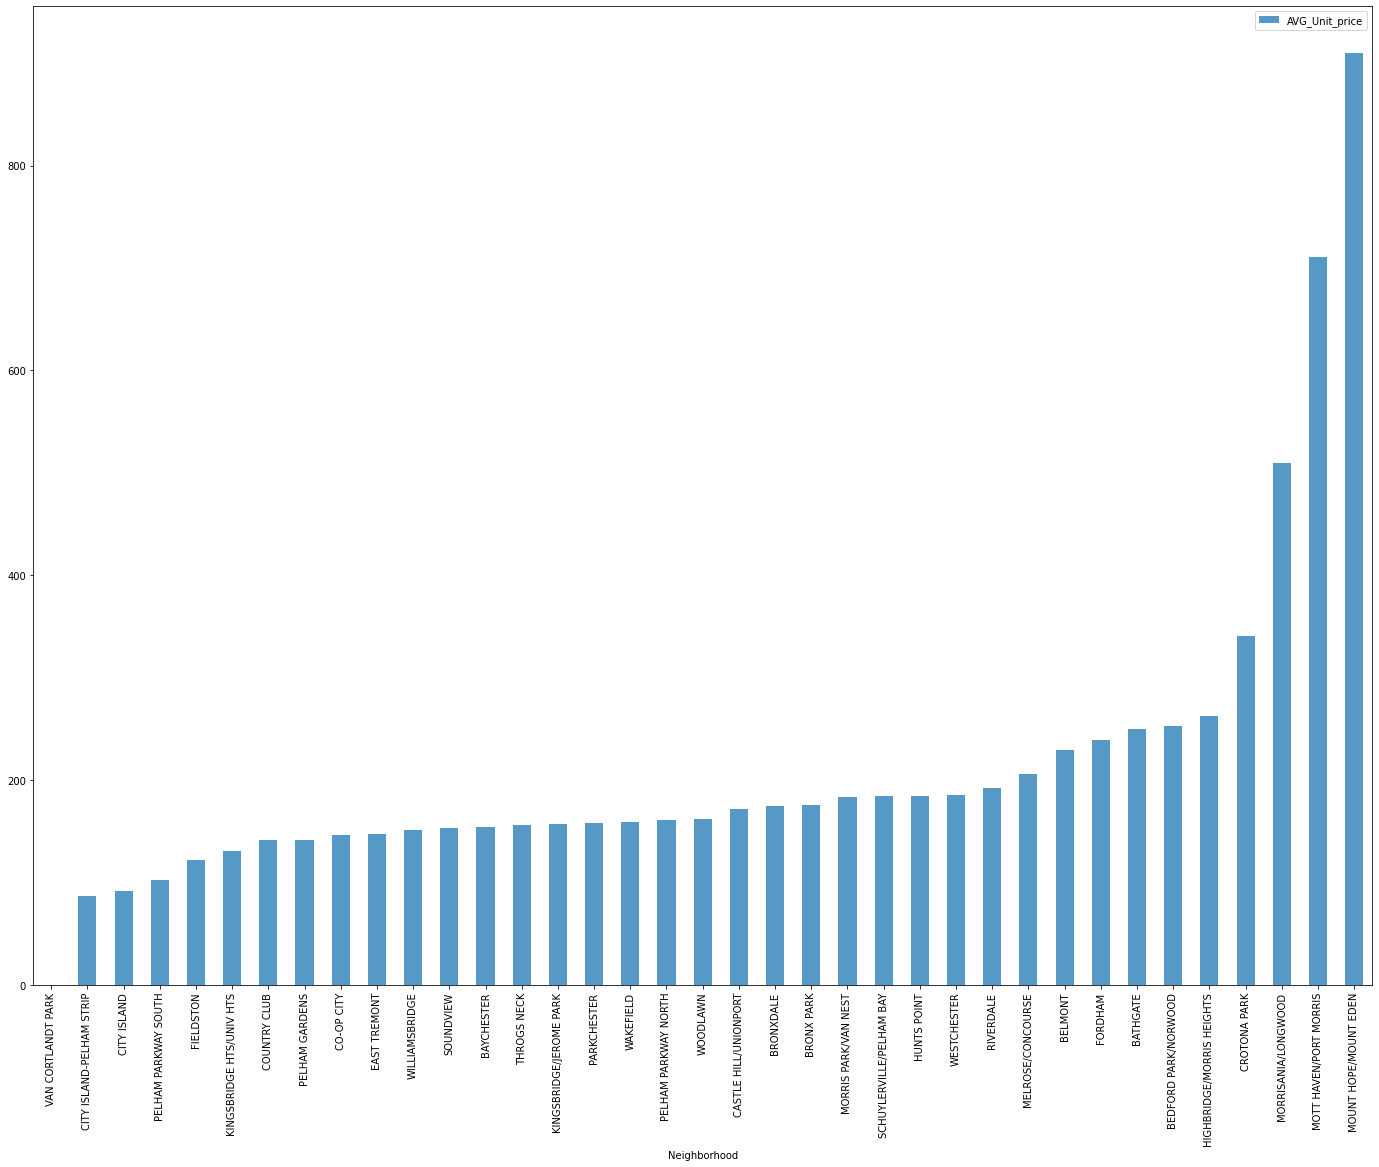

In [26]:
#Create Bar chart for housing price

df_price2.plot(kind='bar',figsize=(24,18),alpha=0.75)

#### MODELING

In [37]:
# Part for K-Mean clustering 
k = 3
clustering = group.drop('Neighborhood',1)
Kmeans = KMeans(n_clusters = k,random_state=0).fit(clustering)
bronx_cluster = Bronx_data
# add clustering labels
bronx_cluster['Cluster Labels'] = Kmeans.labels_

sort_venues['Neighborhood'] = sort_venues['Neighborhood'].str.upper() 
bronx_cluster['Neighborhood'] = bronx_cluster['Neighborhood'].str.upper() 
# merge Manhattan_group_clustering with Manhattan_data to add latitude/longitude for each neighborhood
bronx_cluster= bronx_cluster.join(sort_venues.set_index('Neighborhood'), on='Neighborhood' )
bronx_cluster= bronx_cluster.join(df_price.set_index('Neighborhood'), on='Neighborhood')
bronx_cluster.dropna(axis = 0)

/Users/yitingli/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/Users/yitingli/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1thMost Common Venue,2thMost Common Venue,3thMost Common Venue,4thMost Common Venue,5thMost Common Venue,6thMost Common Venue,7thMost Common Venue,8thMost Common Venue,AVG_Unit_price
0,Bronx,WAKEFIELD,40.894705,-73.847201,0,Pharmacy,Bakery,Caribbean Restaurant,Dessert Shop,Deli / Bodega,Gas Station,Sandwich Place,Food Truck,159.194030
1,Bronx,CO-OP CITY,40.874294,-73.829939,0,Fast Food Restaurant,Grocery Store,Sandwich Place,Donut Shop,Spanish Restaurant,Mattress Store,Shopping Mall,Discount Store,146.000000
3,Bronx,FIELDSTON,40.895437,-73.905643,1,Plaza,Park,Health & Beauty Service,Art Gallery,River,Bus Station,Diner,Eastern European Restaurant,121.576923
4,Bronx,RIVERDALE,40.890834,-73.912585,1,Bank,Health & Beauty Service,Park,Japanese Restaurant,Pizza Place,Playground,Mexican Restaurant,Diner,191.918367
7,Bronx,WOODLAWN,40.898273,-73.867315,1,Pub,Deli / Bodega,Bar,Pizza Place,Bagel Shop,Donut Shop,Brewery,Liquor Store,161.684211
9,Bronx,WILLIAMSBRIDGE,40.881039,-73.857446,2,Caribbean Restaurant,Pizza Place,Pharmacy,Southern / Soul Food Restaurant,Soup Place,Spa,Smoke Shop,Metro Station,151.307895
10,Bronx,BAYCHESTER,40.866858,-73.835798,0,Bus Station,Department Store,Donut Shop,Discount Store,Furniture / Home Store,Clothing Store,Kids Store,Fast Food Restaurant,154.192130
12,Bronx,CITY ISLAND,40.847247,-73.786488,0,Harbor / Marina,Seafood Restaurant,Deli / Bodega,Thrift / Vintage Store,Bar,Italian Restaurant,Spanish Restaurant,Bank,91.318681
16,Bronx,FORDHAM,40.860997,-73.896427,0,Donut Shop,Mobile Phone Shop,Spanish Restaurant,Shoe Store,Pharmacy,Mexican Restaurant,Clothing Store,Pizza Place,239.413793
17,Bronx,EAST TREMONT,40.842696,-73.887356,1,Pizza Place,Fast Food Restaurant,Bank,Fried Chicken Joint,Department Store,Sandwich Place,Donut Shop,Breakfast Spot,147.439560


In [44]:
#Generate Kmean Maps
map_clusters = folium.Map(location=[latitude_man, longitude_man], zoom_start=11)

# set color scheme for the clusters
x = np.arange(k)
colors_array = cm.rainbow(np.linspace(0, 1, k))
rainbow = [colors.rgb2hex(i) for i in colors_array]
print(rainbow)
# add markers to the map

markers_colors = []
for lat, lon, nei , cluster in zip(bronx_cluster['Latitude'], 
                                   bronx_cluster['Longitude'], 
                                   bronx_cluster['Neighborhood'], 
                                   bronx_cluster['Cluster Labels']):

    label = folium.Popup(str(nei) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=3,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)

map_clusters

['#8000ff', '#80ffb4', '#ff0000']


In [40]:
#cluster type 0
type_0_avg = np.mean(bronx_cluster[bronx_cluster['Cluster Labels'] == 0]['AVG_Unit_price'])
print('type 0 cluster average unit price', type_0_avg )
bronx_cluster.loc[bronx_cluster['Cluster Labels'] == 0, bronx_cluster.columns[[1] + list(range(5, bronx_cluster.shape[1]))]]


type 0 cluster average unit price 163.83215880391364


,Neighborhood,1thMost Common Venue,2thMost Common Venue,3thMost Common Venue,4thMost Common Venue,5thMost Common Venue,6thMost Common Venue,7thMost Common Venue,8thMost Common Venue,AVG_Unit_price
0,WAKEFIELD,Pharmacy,Bakery,Caribbean Restaurant,Dessert Shop,Deli / Bodega,Gas Station,Sandwich Place,Food Truck,159.194030
1,CO-OP CITY,Fast Food Restaurant,Grocery Store,Sandwich Place,Donut Shop,Spanish Restaurant,Mattress Store,Shopping Mall,Discount Store,146.000000
2,EASTCHESTER,Caribbean Restaurant,Fast Food Restaurant,Diner,Deli / Bodega,Department Store,Burger Joint,Shopping Mall,Sporting Goods Shop,NaN
5,KINGSBRIDGE,Pizza Place,Sandwich Place,Bar,Bakery,Mexican Restaurant,Gym,Donut Shop,Diner,NaN
8,NORWOOD,Pizza Place,Deli / Bodega,Park,Bank,Fast Food Restaurant,Spanish Restaurant,Pharmacy,Donut Shop,NaN
10,BAYCHESTER,Bus Station,Department Store,Donut Shop,Discount Store,Furniture / Home Store,Clothing Store,Kids Store,Fast Food Restaurant,154.192130
11,PELHAM PARKWAY,Pizza Place,Bakery,Chinese Restaurant,Sandwich Place,Italian Restaurant,Bank,Pharmacy,Cosmetics Shop,NaN
12,CITY ISLAND,Harbor / Marina,Seafood Restaurant,Deli / Bodega,Thrift / Vintage Store,Bar,Italian Restaurant,Spanish Restaurant,Bank,91.318681
14,UNIVERSITY HEIGHTS,Pizza Place,Grocery Store,Bakery,Playground,Fried Chicken Joint,Discount Store,Spanish Restaurant,African Restaurant,NaN
15,MORRIS HEIGHTS,Pizza Place,Chinese Restaurant,Playground,Food Truck,Bank,Pharmacy,Deli / Bodega,Bus Station,NaN


In [41]:
#cluster type 1 
type_1_avg = np.mean(bronx_cluster[bronx_cluster['Cluster Labels'] == 1]['AVG_Unit_price'])
print('type 1 cluster average unit price', type_1_avg )
bronx_cluster.loc[bronx_cluster['Cluster Labels'] == 1, bronx_cluster.columns[[1] + list(range(5, bronx_cluster.shape[1]))]]



type 1 cluster average unit price 155.6547653474345


,Neighborhood,1thMost Common Venue,2thMost Common Venue,3thMost Common Venue,4thMost Common Venue,5thMost Common Venue,6thMost Common Venue,7thMost Common Venue,8thMost Common Venue,AVG_Unit_price
3,FIELDSTON,Plaza,Park,Health & Beauty Service,Art Gallery,River,Bus Station,Diner,Eastern European Restaurant,121.576923
4,RIVERDALE,Bank,Health & Beauty Service,Park,Japanese Restaurant,Pizza Place,Playground,Mexican Restaurant,Diner,191.918367
7,WOODLAWN,Pub,Deli / Bodega,Bar,Pizza Place,Bagel Shop,Donut Shop,Brewery,Liquor Store,161.684211
13,BEDFORD PARK,Pizza Place,Chinese Restaurant,Diner,Deli / Bodega,Sandwich Place,Mexican Restaurant,Grocery Store,Pharmacy,NaN
17,EAST TREMONT,Pizza Place,Fast Food Restaurant,Bank,Fried Chicken Joint,Department Store,Sandwich Place,Donut Shop,Breakfast Spot,147.439560
27,CLASON POINT,Park,Bus Stop,Pool,Boat or Ferry,South American Restaurant,Convenience Store,Grocery Store,River,NaN
32,VAN NEST,Pizza Place,Bus Station,Deli / Bodega,Italian Restaurant,Middle Eastern Restaurant,Hookah Bar,Bowling Alley,Donut Shop,NaN
36,NORTH RIVERDALE,Pizza Place,Bus Station,Pool,Italian Restaurant,Chinese Restaurant,Deli / Bodega,Sushi Restaurant,Bank,NaN
38,SCHUYLERVILLE,Pizza Place,Bar,Pharmacy,Diner,Mexican Restaurant,Italian Restaurant,Sushi Restaurant,Bank,NaN
40,CASTLE HILL,Baseball Field,Bus Station,Pizza Place,Park,Market,Supermarket,Shopping Mall,Bank,NaN


In [42]:
#cluster type 2
type_2_avg = np.mean(bronx_cluster[bronx_cluster['Cluster Labels'] == 2]['AVG_Unit_price'])
print('type 2 cluster average unit price', type_2_avg )
bronx_cluster.loc[bronx_cluster['Cluster Labels'] == 2, bronx_cluster.columns[[1] + list(range(5, bronx_cluster.shape[1]))]]




type 2 cluster average unit price 151.30789473684212


,Neighborhood,1thMost Common Venue,2thMost Common Venue,3thMost Common Venue,4thMost Common Venue,5thMost Common Venue,6thMost Common Venue,7thMost Common Venue,8thMost Common Venue,AVG_Unit_price
9,WILLIAMSBRIDGE,Caribbean Restaurant,Pizza Place,Pharmacy,Southern / Soul Food Restaurant,Soup Place,Spa,Smoke Shop,Metro Station,151.307895
18,WEST FARMS,Park,Zoo,Breakfast Spot,Fast Food Restaurant,Pizza Place,Supermarket,Shopping Mall,Discount Store,NaN
43,CONCOURSE,Spanish Restaurant,Fried Chicken Joint,Pizza Place,Grocery Store,Deli / Bodega,Donut Shop,Cosmetics Shop,Fast Food Restaurant,NaN


In [43]:
#cluster type 3
type_3_avg = np.mean(bronx_cluster[bronx_cluster['Cluster Labels'] == 3]['AVG_Unit_price'])

bronx_cluster.loc[bronx_cluster['Cluster Labels'] == 3, bronx_cluster.columns[[1] + list(range(5, bronx_cluster.shape[1]))]]




,Neighborhood,1thMost Common Venue,2thMost Common Venue,3thMost Common Venue,4thMost Common Venue,5thMost Common Venue,6thMost Common Venue,7thMost Common Venue,8thMost Common Venue,AVG_Unit_price


In [33]:
#bronx_cluster.loc[bronx_cluster['Cluster Labels'] == 4, bronx_cluster.columns[[1] + list(range(5, bronx_cluster.shape[1]))]]




In [34]:
#spectral clustering
from sklearn.cluster import SpectralClustering

In [35]:
# Part for spectral clustering 
k = 2
clustering = group.drop('Neighborhood',1)
SpectralClustering = SpectralClustering(n_clusters = k,random_state=0).fit(clustering)
bronx_cluster = Bronx_data
# add clustering labels
bronx_cluster['Cluster Labels'] = SpectralClustering.labels_

sort_venues['Neighborhood'] = sort_venues['Neighborhood'].str.upper() 
bronx_cluster['Neighborhood'] = bronx_cluster['Neighborhood'].str.upper() 
# merge Manhattan_group_clustering with Manhattan_data to add latitude/longitude for each neighborhood
bronx_cluster= bronx_cluster.join(sort_venues.set_index('Neighborhood'), on='Neighborhood' )
bronx_cluster= bronx_cluster.join(df_price.set_index('Neighborhood'), on='Neighborhood')
bronx_cluster.dropna(axis = 0)

/Users/yitingli/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/Users/yitingli/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1thMost Common Venue,2thMost Common Venue,3thMost Common Venue,4thMost Common Venue,5thMost Common Venue,6thMost Common Venue,7thMost Common Venue,8thMost Common Venue,AVG_Unit_price
0,Bronx,WAKEFIELD,40.894705,-73.847201,1,Pharmacy,Bakery,Caribbean Restaurant,Dessert Shop,Deli / Bodega,Gas Station,Sandwich Place,Food Truck,159.194030
1,Bronx,CO-OP CITY,40.874294,-73.829939,1,Fast Food Restaurant,Grocery Store,Sandwich Place,Donut Shop,Spanish Restaurant,Mattress Store,Shopping Mall,Discount Store,146.000000
3,Bronx,FIELDSTON,40.895437,-73.905643,1,Plaza,Park,Health & Beauty Service,Art Gallery,River,Bus Station,Diner,Eastern European Restaurant,121.576923
4,Bronx,RIVERDALE,40.890834,-73.912585,1,Bank,Health & Beauty Service,Park,Japanese Restaurant,Pizza Place,Playground,Mexican Restaurant,Diner,191.918367
7,Bronx,WOODLAWN,40.898273,-73.867315,1,Pub,Deli / Bodega,Bar,Pizza Place,Bagel Shop,Donut Shop,Brewery,Liquor Store,161.684211
9,Bronx,WILLIAMSBRIDGE,40.881039,-73.857446,0,Caribbean Restaurant,Pizza Place,Pharmacy,Southern / Soul Food Restaurant,Soup Place,Spa,Smoke Shop,Metro Station,151.307895
10,Bronx,BAYCHESTER,40.866858,-73.835798,1,Bus Station,Department Store,Donut Shop,Discount Store,Furniture / Home Store,Clothing Store,Kids Store,Fast Food Restaurant,154.192130
12,Bronx,CITY ISLAND,40.847247,-73.786488,1,Harbor / Marina,Seafood Restaurant,Deli / Bodega,Thrift / Vintage Store,Bar,Italian Restaurant,Spanish Restaurant,Bank,91.318681
16,Bronx,FORDHAM,40.860997,-73.896427,1,Donut Shop,Mobile Phone Shop,Spanish Restaurant,Shoe Store,Pharmacy,Mexican Restaurant,Clothing Store,Pizza Place,239.413793
17,Bronx,EAST TREMONT,40.842696,-73.887356,1,Pizza Place,Fast Food Restaurant,Bank,Fried Chicken Joint,Department Store,Sandwich Place,Donut Shop,Breakfast Spot,147.439560


In [36]:
#Generate spectral Maps
map_clusters = folium.Map(location=[latitude_man, longitude_man], zoom_start=11)

# set color scheme for the clusters
x = np.arange(k)
colors_array = cm.rainbow(np.linspace(0, 1, k))
rainbow = [colors.rgb2hex(i) for i in colors_array]
print(rainbow)
# add markers to the map

markers_colors = []
for lat, lon, nei , cluster in zip(bronx_cluster['Latitude'], 
                                   bronx_cluster['Longitude'], 
                                   bronx_cluster['Neighborhood'], 
                                   bronx_cluster['Cluster Labels']):
    label = folium.Popup(str(nei) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)

map_clusters

['#8000ff', '#ff0000']
